In [22]:
import re
import string
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


[nltk_data] Downloading package stopwords to /home/nikita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nikita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nikita/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/nikita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

In [4]:
train_df_original = pd.read_csv('../data/row_data.csv')

In [5]:
train_df_original.head()

,Annotator ID,Text,Answer
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True


In [6]:
train_df = train_df_original.groupby(by='Text').apply(
    lambda x: pd.Series({'agreement_rate': x['Answer'].sum() / x['Answer'].size})
).reset_index()

In [7]:
agreement_rate_dist = train_df['agreement_rate'].value_counts().sort_index()

<BarContainer object of 7 artists>

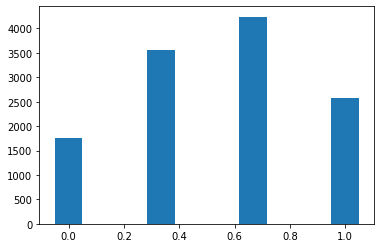

In [8]:
plt.bar(x=agreement_rate_dist.index, height=agreement_rate_dist, width=0.1)

In [9]:
train_df = train_df[(train_df['agreement_rate'] == 0) | (train_df['agreement_rate'] == 1)]

In [10]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [11]:
# Applying helper functions

train_df['text_clean'] = train_df['Text'].apply(lambda x: remove_URL(x))
train_df['text_clean'] = train_df['text_clean'].apply(lambda x: remove_emoji(x))
train_df['text_clean'] = train_df['text_clean'].apply(lambda x: remove_html(x))
train_df['text_clean'] = train_df['text_clean'].apply(lambda x: remove_punct(x))

In [12]:
train_df.head()

,Text,agreement_rate,text_clean
1,# Binance has been hacked. #��� In a world of ...,1.0,Binance has been hacked In a world of blockc...
2,#2FA secret code? #Passwords? This #hack is ju...,1.0,2FA secret code Passwords This hack is just an...
3,#ALTSEASON STARTS WHEN MARGIN TRADING @ BINANC...,0.0,ALTSEASON STARTS WHEN MARGIN TRADING BINANCE ...
4,#AMIS on #Etherdelta IBM y AMIS le apuestan al...,0.0,AMIS on Etherdelta IBM y AMIS le apuestan al b...
5,#AtomicWallet<span class='emoji-bytes' data-em...,0.0,AtomicWallet has implemented the best solution...


In [13]:
# Tokenizing the tweet base texts.

train_df['tokenized'] = train_df['text_clean'].apply(word_tokenize)

train_df.head()

,Text,agreement_rate,text_clean,tokenized
1,# Binance has been hacked. #��� In a world of ...,1.0,Binance has been hacked In a world of blockc...,"[Binance, has, been, hacked, In, a, world, of,..."
2,#2FA secret code? #Passwords? This #hack is ju...,1.0,2FA secret code Passwords This hack is just an...,"[2FA, secret, code, Passwords, This, hack, is,..."
3,#ALTSEASON STARTS WHEN MARGIN TRADING @ BINANC...,0.0,ALTSEASON STARTS WHEN MARGIN TRADING BINANCE ...,"[ALTSEASON, STARTS, WHEN, MARGIN, TRADING, BIN..."
4,#AMIS on #Etherdelta IBM y AMIS le apuestan al...,0.0,AMIS on Etherdelta IBM y AMIS le apuestan al b...,"[AMIS, on, Etherdelta, IBM, y, AMIS, le, apues..."
5,#AtomicWallet<span class='emoji-bytes' data-em...,0.0,AtomicWallet has implemented the best solution...,"[AtomicWallet, has, implemented, the, best, so..."


In [14]:
# Lower casing clean text.

train_df['lower'] = train_df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

train_df.head()

,Text,agreement_rate,text_clean,tokenized,lower
1,# Binance has been hacked. #��� In a world of ...,1.0,Binance has been hacked In a world of blockc...,"[Binance, has, been, hacked, In, a, world, of,...","[binance, has, been, hacked, in, a, world, of,..."
2,#2FA secret code? #Passwords? This #hack is ju...,1.0,2FA secret code Passwords This hack is just an...,"[2FA, secret, code, Passwords, This, hack, is,...","[2fa, secret, code, passwords, this, hack, is,..."
3,#ALTSEASON STARTS WHEN MARGIN TRADING @ BINANC...,0.0,ALTSEASON STARTS WHEN MARGIN TRADING BINANCE ...,"[ALTSEASON, STARTS, WHEN, MARGIN, TRADING, BIN...","[altseason, starts, when, margin, trading, bin..."
4,#AMIS on #Etherdelta IBM y AMIS le apuestan al...,0.0,AMIS on Etherdelta IBM y AMIS le apuestan al b...,"[AMIS, on, Etherdelta, IBM, y, AMIS, le, apues...","[amis, on, etherdelta, ibm, y, amis, le, apues..."
5,#AtomicWallet<span class='emoji-bytes' data-em...,0.0,AtomicWallet has implemented the best solution...,"[AtomicWallet, has, implemented, the, best, so...","[atomicwallet, has, implemented, the, best, so..."


In [15]:
# Removing stopwords.

train_df['stopwords_removed'] = train_df['lower'].apply(
    lambda x: [word for word in x if word not in stop])

train_df.head()

,Text,agreement_rate,text_clean,tokenized,lower,stopwords_removed
1,# Binance has been hacked. #��� In a world of ...,1.0,Binance has been hacked In a world of blockc...,"[Binance, has, been, hacked, In, a, world, of,...","[binance, has, been, hacked, in, a, world, of,...","[binance, hacked, world, blockchain, transpare..."
2,#2FA secret code? #Passwords? This #hack is ju...,1.0,2FA secret code Passwords This hack is just an...,"[2FA, secret, code, Passwords, This, hack, is,...","[2fa, secret, code, passwords, this, hack, is,...","[2fa, secret, code, passwords, hack, another, ..."
3,#ALTSEASON STARTS WHEN MARGIN TRADING @ BINANC...,0.0,ALTSEASON STARTS WHEN MARGIN TRADING BINANCE ...,"[ALTSEASON, STARTS, WHEN, MARGIN, TRADING, BIN...","[altseason, starts, when, margin, trading, bin...","[altseason, starts, margin, trading, binance, ..."
4,#AMIS on #Etherdelta IBM y AMIS le apuestan al...,0.0,AMIS on Etherdelta IBM y AMIS le apuestan al b...,"[AMIS, on, Etherdelta, IBM, y, AMIS, le, apues...","[amis, on, etherdelta, ibm, y, amis, le, apues...","[amis, etherdelta, ibm, amis, le, apuestan, al..."
5,#AtomicWallet<span class='emoji-bytes' data-em...,0.0,AtomicWallet has implemented the best solution...,"[AtomicWallet, has, implemented, the, best, so...","[atomicwallet, has, implemented, the, best, so...","[atomicwallet, implemented, best, solution, ma..."


In [18]:
train_df['agreement_rate'] = train_df['agreement_rate'].astype(int)

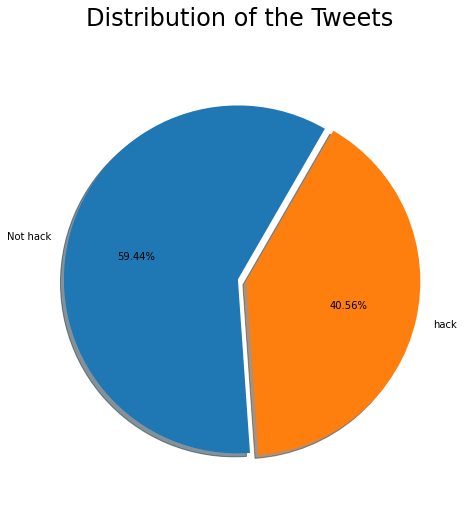

In [24]:
# Displaying target distribution.

plt.figure(figsize=(8, 8))

plt.pie(
    train_df['agreement_rate'].value_counts(),
    labels=['Not hack', 'hack'],
    autopct='%1.2f%%',
    shadow=True,
    explode=(0.05, 0),
    startangle=60
)
plt.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [25]:
# Creating a new feature for the visualization.
train_df['Character Count'] = train_df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))

    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])

    # Set the title.
    ax1.set_title('Histogram')

    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])

    # Set the title.
    ax2.set_title('Empirical CDF')

    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])

    # Set title.
    ax3.set_title('Box Plot')
    
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

/tmp/ipykernel_304639/400665430.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, feature],
/tmp/ipykernel_304639/400665430.py:34: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, feature],
/home/nikita/anaconda3/envs/happywhale/lib/python3.9/site-packages/seaborn/_oldcore.py

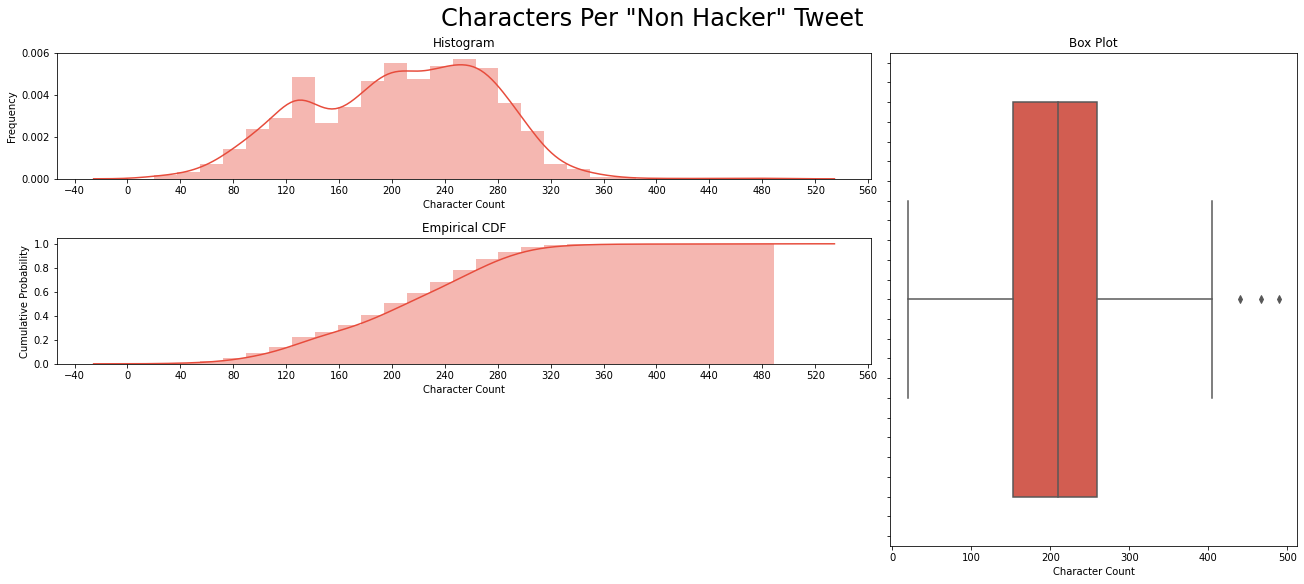

In [26]:
plot_dist3(train_df[train_df['agreement_rate'] == 0], 'Character Count',
           'Characters Per "Non Hacker" Tweet')

/tmp/ipykernel_304639/400665430.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, feature],
/tmp/ipykernel_304639/400665430.py:34: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, feature],
/home/nikita/anaconda3/envs/happywhale/lib/python3.9/site-packages/seaborn/_oldcore.py

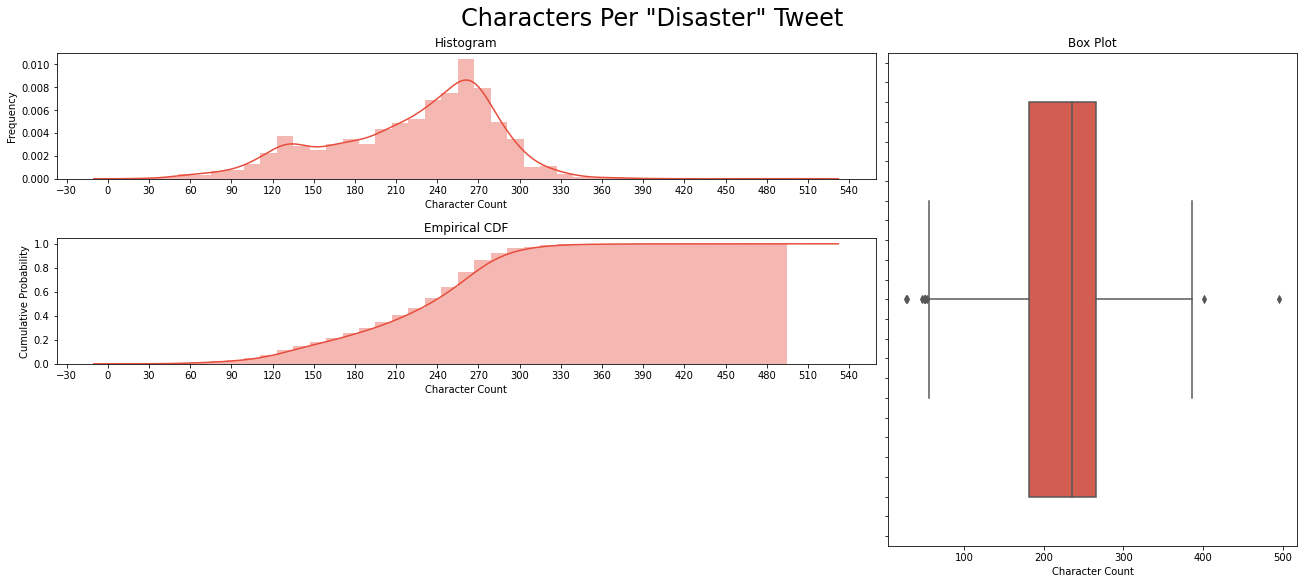

In [27]:
plot_dist3(train_df[train_df['agreement_rate'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

In [28]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

/tmp/ipykernel_304639/1585757681.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
/tmp/ipykernel_304639/1585757681.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], c

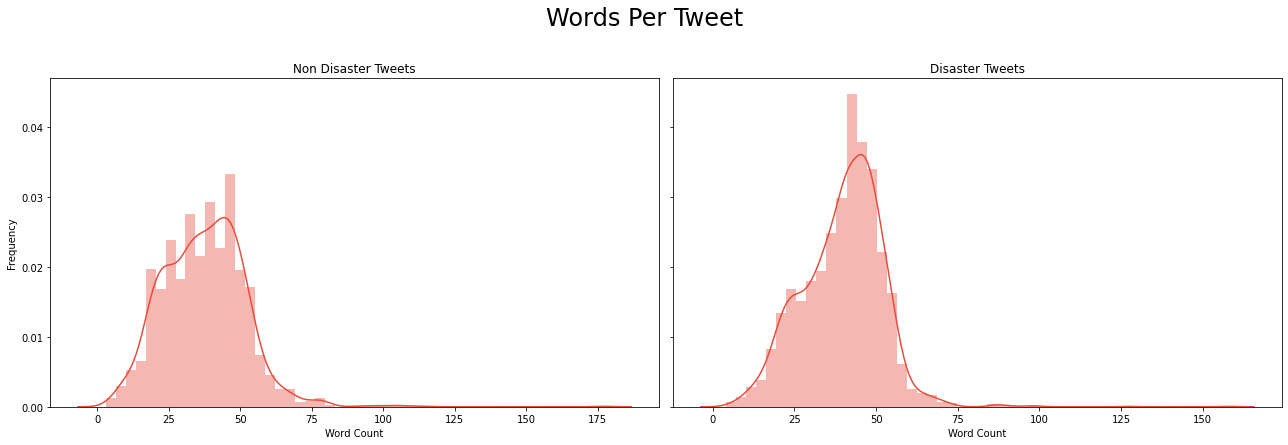

In [29]:
plot_word_number_histogram(train_df[train_df['agreement_rate'] == 0]['Text'],
                           train_df[train_df['agreement_rate'] == 1]['Text'])

In [30]:
lis = [
    train_df[train_df['agreement_rate'] == 0]['stopwords_removed'],
    train_df[train_df['agreement_rate'] == 1]['stopwords_removed']
]

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


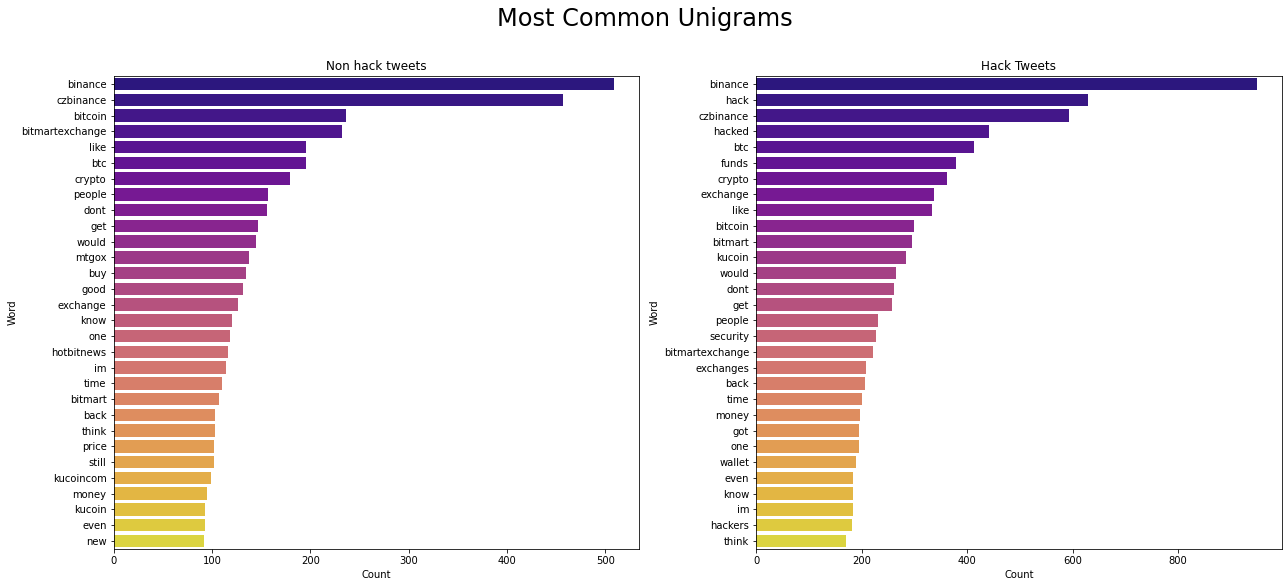

In [33]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for new, j in zip(lis, axes):
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non hack tweets')

axes[1].set_title('Hack Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [34]:
train_df

,Text,agreement_rate,text_clean,tokenized,lower,stopwords_removed,pos_tags,Character Count
1,# Binance has been hacked. #��� In a world of ...,1,Binance has been hacked In a world of blockc...,"[Binance, has, been, hacked, In, a, world, of,...","[binance, has, been, hacked, in, a, world, of,...","[binance, hacked, world, blockchain, transpare...","[(binance, NN), (hacked, VBD), (world, NN), (b...",252
2,#2FA secret code? #Passwords? This #hack is ju...,1,2FA secret code Passwords This hack is just an...,"[2FA, secret, code, Passwords, This, hack, is,...","[2fa, secret, code, passwords, this, hack, is,...","[2fa, secret, code, passwords, hack, another, ...","[(2fa, CD), (secret, JJ), (code, NN), (passwor...",206
3,#ALTSEASON STARTS WHEN MARGIN TRADING @ BINANC...,0,ALTSEASON STARTS WHEN MARGIN TRADING BINANCE ...,"[ALTSEASON, STARTS, WHEN, MARGIN, TRADING, BIN...","[altseason, starts, when, margin, trading, bin...","[altseason, starts, margin, trading, binance, ...","[(altseason, NN), (starts, VBZ), (margin, NN),...",94
4,#AMIS on #Etherdelta IBM y AMIS le apuestan al...,0,AMIS on Etherdelta IBM y AMIS le apuestan al b...,"[AMIS, on, Etherdelta, IBM, y, AMIS, le, apues...","[amis, on, etherdelta, ibm, y, amis, le, apues...","[amis, etherdelta, ibm, amis, le, apuestan, al...","[(amis, NN), (etherdelta, NN), (ibm, NN), (ami...",86
5,#AtomicWallet<span class='emoji-bytes' data-em...,0,AtomicWallet has implemented the best solution...,"[AtomicWallet, has, implemented, the, best, so...","[atomicwallet, has, implemented, the, best, so...","[atomicwallet, implemented, best, solution, ma...","[(atomicwallet, NN), (implemented, VBN), (best...",156
...,...,...,...,...,...,...,...,...
12126,"������ Binance Hack - 7,000 #Bitcoin stolenTod...",1,Binance Hack 7000 Bitcoin stolenToday Binanc...,"[Binance, Hack, 7000, Bitcoin, stolenToday, Bi...","[binance, hack, 7000, bitcoin, stolentoday, bi...","[binance, hack, 7000, bitcoin, stolentoday, bi...","[(binance, NN), (hack, NN), (7000, CD), (bitco...",237
12127,������ Business as usual after the hacking inc...,1,Business as usual after the hacking incident ...,"[Business, as, usual, after, the, hacking, inc...","[business, as, usual, after, the, hacking, inc...","[business, usual, hacking, incident, kucoincom...","[(business, NN), (usual, JJ), (hacking, NN), (...",230
12133,������Another Exchange Hacked.People Keep your...,1,Another Exchange HackedPeople Keep your Digita...,"[Another, Exchange, HackedPeople, Keep, your, ...","[another, exchange, hackedpeople, keep, your, ...","[another, exchange, hackedpeople, keep, digita...","[(another, DT), (exchange, NN), (hackedpeople,...",228
12135,������Today's #cryptonews:- #ICE has sold its ...,1,Todays cryptonews ICE has sold its stake in Co...,"[Todays, cryptonews, ICE, has, sold, its, stak...","[todays, cryptonews, ice, has, sold, its, stak...","[todays, cryptonews, ice, sold, stake, coinbas...","[(todays, NNS), (cryptonews, NNS), (ice, RB), ...",218


In [35]:
from transformers import BertTokenizer

/home/nikita/anaconda3/envs/happywhale/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading: 100%|██████████| 226k/226k [00:00<00:00, 405kB/s] 
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 12.5kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 277kB/s]


## Check maximum BERT tweet length

In [44]:
train_df_original['text_without_li_sp_em'] = \
    train_df_original['Text'].apply(lambda x: remove_URL(x))
train_df_original['text_without_li_sp_em'] = \
    train_df_original['text_without_li_sp_em'].apply(lambda x: remove_emoji(x))
train_df_original['text_without_li_sp_em'] = \
    train_df_original['text_without_li_sp_em'].apply(lambda x: remove_html(x))

train_df['text_without_li_sp_em'] = \
    train_df['Text'].apply(lambda x: remove_URL(x))
train_df['text_without_li_sp_em'] = \
    train_df['text_without_li_sp_em'].apply(lambda x: remove_emoji(x))
train_df['text_without_li_sp_em'] = \
    train_df['text_without_li_sp_em'].apply(lambda x: remove_html(x))

In [64]:
max_len = 0

for text in train_df_original.groupby(by='Text').groups.keys():    
    input_ids = tokenizer.encode(text, add_special_tokens=True)    
    max_len = max(max_len, len(input_ids))

print('Max sentence length for row text: ', max_len)

max_len = 0

for text in train_df_original.text_without_li_sp_em:    
    input_ids = tokenizer.encode(text, add_special_tokens=True)    
    max_len = max(max_len, len(input_ids))

print('Max sentence length for text after removing links, emojis and htmls: ', max_len)

max_len = 0
longest_train_text = None
for text in train_df.text_without_li_sp_em:    
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if max_len < len(input_ids):
        longest_train_text = text
    max_len = max(max_len, len(input_ids))

print('Max sentence length for training text only after removing links, emojis and htmls: ', max_len)

Max sentence length for row text:  993
Max sentence length for text after removing links, emojis and htmls:  185
Max sentence length for training text only after removing links, emojis and htmls:  185


In [65]:
print("Longest text in train dataset for BERT - ", longest_train_text)

Longest text in train dataset for BERT -  @ArkadiahF @FUNCTIONX_IO @PundiXLabs @zibin @binance @cz_binance @kucoincom @Hotbit_news @HuobiGlobal @BittrexExchange @Poloniex @krakenfx @Byte_Produce @odesk_mouhcine @PundiXFunctionX @PundiXLabs_jp @wanchain_org @Pundixforce1 @RealSahabia @RussellOkung I must admit, things are really heating up with #Fx @FUNCTIONX_IO. upcoming #mainnet is a game changer  with a passionate team like @PundiXLabs, investment is #SAFUSit back enjoy the #staking reward  wait patiently for #mainnet then #Lambo@zibin abd team, take us to mainnet
